In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# Data Description

* **InvoiceNo   :**  Unique invoice number for each transaction
* **StockCode   :**  Unique code identifying each product
* **Description :**  Name or description of the product
* **Quantity    :**  Number of product units sold
* **InvoiceDate :**  Date and time when the transaction occurred
* **UnitPrice   :**  Price per unit of the product
* **CustomerID  :**  Unique identifier number for each customer
* **Country     :**  Country where the customer made the transaction

# Data Cleaning & Preparation

In [ ]:
df = pd.read_csv('/content/data.csv', encoding='latin-1')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [ ]:
# missing values per column
missing_per_column = df.isna().sum()
print("number of missing values per column:")
print(missing_per_column)

num_duplicates = df.duplicated().sum()
print("number of duplicate rows:", num_duplicates)


number of missing values per column:
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64
number of duplicate rows: 5268


In [ ]:
df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 536641 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    536641 non-null  object 
 1   StockCode    536641 non-null  object 
 2   Description  535187 non-null  object 
 3   Quantity     536641 non-null  int64  
 4   InvoiceDate  536641 non-null  object 
 5   UnitPrice    536641 non-null  float64
 6   CustomerID   401604 non-null  float64
 7   Country      536641 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 36.8+ MB


There are missing values in the **Description** and **CustomerID** columns, and the **InvoiceDate** column is not yet in a datetime format.
To handle missing values in **CustomerID**, rows containing null values should be dropped.
Meanwhile, missing values in **Description** can be filled using the StockCode reference if there are identical product codes with existing descriptions. Additionally, a new column called **Revenue** should be created by multiplying Quantity and UnitPrice to represent the total sales amount for each transaction

However, since the number of missing values in **CustomerID** is quite large, it would be wise to split the dataset into two DataFrames.
The first DataFrame (which still contains missing CustomerID values) can be used for **sales or product analysis**, as transaction and item information remain valuable.
The second DataFrame, after removing rows with missing CustomerID, can be utilized for **customer behavior analysis**, where customer identification is essential.

In [ ]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')
df['CustomerID'] = df['CustomerID'].astype(str)
df['InvoiceYearMonth'] = df['InvoiceDate'].dt.to_period('M')
df['InvoiceDate_only'] = df['InvoiceDate'].dt.date
df['Revenue'] = df['Quantity'] * df['UnitPrice']

In [ ]:
# contains valid punctuation marks used in product descriptions
allowed_punct = r""".,:/()&+'!£"-* """


# find characters that are not letters, numbers, or allowed punctuation marks
pattern = rf"[^a-zA-Z0-9{re.escape(allowed_punct)}]"

mask_weird = df['Description'].astype(str).str.contains(pattern, na=False)
num_weird = mask_weird.sum()
print("Number of rows with strange contents:", num_weird)
print(df.loc[mask_weird, 'Description'].unique())

Number of rows with strange contents: 82
['?' '? sold as sets?' '?sold as sets?' '?lost' 'damages?' 'sold in set?'
 'POSSIBLE DAMAGES OR LOST?' 'wrong code?' 'damages/dotcom?'
 'code mix up? 84930' '?display?' '?missing' '??'
 'historic computer difference?....se' 'missing?' '???lost' 'check?'
 '?? missing' '????missing' '???missing' 'wet?' 'lost??' '???'
 '????damages????']


It turns out that many **Description** are still unclear. Therefore, revise the unclear descriptions and match them with the appropriate **StockCode** references

In [ ]:
df.loc[mask_weird, 'Description'] = pd.NA
df['Description'].isna().sum()

np.int64(1536)

In [ ]:
#Create a dictionary mapping from StockCode to Description
stockcode_to_desc = df.dropna(subset=['Description']).drop_duplicates('StockCode').set_index('StockCode')['Description'].to_dict()

#Fill missing Description values based on StockCode
df['Description'] = df.apply(
    lambda row: stockcode_to_desc[row['StockCode']] if pd.isna(row['Description']) and row['StockCode'] in stockcode_to_desc else row['Description'],
    axis=1
)
missing_desc_count = df['Description'].isna().sum()
print("Number of descriptions that are still missing:", missing_desc_count)

Number of descriptions that are still missing: 112


The number of rows with missing values has decreased from 1,536 to just 112. Since this is a relatively small amount, it’s reasonable to drop these rows

In [ ]:
df = df.dropna(subset=['Description'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 536529 entries, 0 to 541908
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   InvoiceNo         536529 non-null  object        
 1   StockCode         536529 non-null  object        
 2   Description       536529 non-null  object        
 3   Quantity          536529 non-null  int64         
 4   InvoiceDate       536529 non-null  datetime64[ns]
 5   UnitPrice         536529 non-null  float64       
 6   CustomerID        536529 non-null  object        
 7   Country           536529 non-null  object        
 8   InvoiceYearMonth  536529 non-null  period[M]     
 9   InvoiceDate_only  536529 non-null  object        
 10  Revenue           536529 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(6), period[M](1)
memory usage: 49.1+ MB


In [ ]:
num_col = df[['Quantity', 'UnitPrice']]
num_col.describe()


,Quantity,UnitPrice
count,536529.000000,536529.000000
mean,9.623748,4.633623
std,219.152755,97.243243
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


Based on the minimum and maximum values in the **Quantity** and **UnitPrice** columns, there are negative and extremely high values. These values are unreasonable and should be further **investigated**.

In [ ]:
df_negative = df[df['Quantity'] < 0]
print("number of rows with negative quantity:", len(df_negative))
df_negative.head(10)

number of rows with negative quantity: 10490


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYearMonth,InvoiceDate_only,Revenue
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom,2010-12,2010-12-01,-27.50
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom,2010-12,2010-12-01,-4.65
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom,2010-12,2010-12-01,-19.80
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,2010-12,2010-12-01,-6.96
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,2010-12,2010-12-01,-6.96
238,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,2010-12,2010-12-01,-6.96
239,C536391,21484,CHICK GREY HOT WATER BOTTLE,-12,2010-12-01 10:24:00,3.45,17548.0,United Kingdom,2010-12,2010-12-01,-41.40
240,C536391,22557,PLASTERS IN TIN VINTAGE PAISLEY,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom,2010-12,2010-12-01,-19.80
241,C536391,22553,PLASTERS IN TIN SKULLS,-24,2010-12-01 10:24:00,1.65,17548.0,United Kingdom,2010-12,2010-12-01,-39.60
939,C536506,22960,JAM MAKING SET WITH JARS,-6,2010-12-01 12:38:00,4.25,17897.0,United Kingdom,2010-12,2010-12-01,-25.50


In [ ]:
# Retrieve data with extreme Quantity values (above the 99th percentile)
df_extreme = df[df['Quantity'] > df['Quantity'].quantile(0.99)]

print("Number of rows with extreme Quantity:", len(df_extreme))

# Sort by Quantity in descending order
df_extreme_sorted = df_extreme.sort_values(by='Quantity', ascending=False)

# Display the top 10 rows
df_extreme_sorted.head(10)


Number of rows with extreme Quantity: 4948


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYearMonth,InvoiceDate_only,Revenue
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom,2011-12,2011-12-09,168469.60
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,2011-01,2011-01-18,77183.60
502122,578841,84826,ASSTD DESIGN 3D PAPER STICKERS,12540,2011-11-25 15:57:00,0.00,13256.0,United Kingdom,2011-11,2011-11-25,0.00
74614,542504,37413,ICON MUG REVOLUTIONARY,5568,2011-01-28 12:03:00,0.00,nan,United Kingdom,2011-01,2011-01-28,0.00
421632,573008,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,4800,2011-10-27 12:26:00,0.21,12901.0,United Kingdom,2011-10,2011-10-27,1008.00
206121,554868,22197,SMALL POPCORN HOLDER,4300,2011-05-27 10:52:00,0.72,13135.0,United Kingdom,2011-05,2011-05-27,3096.00
220843,556231,85123A,WHITE HANGING HEART T-LIGHT HOLDER,4000,2011-06-09 15:04:00,0.00,nan,United Kingdom,2011-06,2011-06-09,0.00
97432,544612,22053,EMPIRE DESIGN ROSETTE,3906,2011-02-22 10:43:00,0.82,18087.0,United Kingdom,2011-02,2011-02-22,3202.92
270885,560599,18007,ESSENTIAL BALM 3.5g TIN IN ENVELOPE,3186,2011-07-19 17:04:00,0.06,14609.0,United Kingdom,2011-07,2011-07-19,191.16
160546,550461,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,3114,2011-04-18 13:20:00,2.10,15749.0,United Kingdom,2011-04,2011-04-18,6539.40


It can be seen that transactions with negative or unusually high quantities may be caused by returns, gifts/samples, or lost/damaged items. This is further supported by the UnitPrice values. Therefore, a new column can be created to label the transaction category based on the patterns of Quantity and UnitPrice



In [ ]:
def categorize(row):
    if row['Quantity'] < 0:
        if row['UnitPrice'] == 0 or pd.isna(row['CustomerID']):
            return 'Lost/Damaged'
        else:
            return 'Customer Return'
    elif row['Quantity'] > 0 and row['UnitPrice'] == 0:
        return 'Promo/Sample'
    else:
        return 'Normal Sale'

df['Category'] = df.apply(categorize, axis=1)

df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYearMonth,InvoiceDate_only,Revenue,Category
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12,2010-12-01,15.30,Normal Sale
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12,2010-12-01,20.34,Normal Sale
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12,2010-12-01,22.00,Normal Sale
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12,2010-12-01,20.34,Normal Sale
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12,2010-12-01,20.34,Normal Sale


For a more accurate analysis, I will divide the data into three DataFrames: **df_customer, df_sales, and df_adjustment**


In [ ]:
df_sales = df[df['Category'] == 'Normal Sale']
df_adjustment = df[df['Category'] != 'Normal Sale']
df_customer = df_sales.dropna(subset=['CustomerID'])

To assess the losses caused by lost or damaged items, I fill the zero values with prices mapped from the StockCode

In [ ]:
# 1. Create a mapping of normal prices per StockCode from normal transactions (Quantity > 0 and UnitPrice > 0)
price_map = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)].groupby('StockCode')['UnitPrice'].mean()

# 2. Create a mask for only Lost/Damaged transactions in df_adjustment
mask_lost = df_adjustment['Category'] == 'Lost/Damaged'

# 3. Fill UnitPrice = 0 using the StockCode mapping
mask_fill = mask_lost & (df_adjustment['UnitPrice'] == 0) & (df_adjustment['StockCode'].isin(price_map.index))
df_adjustment.loc[mask_fill, 'UnitPrice'] = df_adjustment.loc[mask_fill, 'StockCode'].map(price_map)


In [ ]:
# Filter only Lost/Damaged rows
df_lost = df_adjustment[df_adjustment['Category'] == 'Lost/Damaged']

# Mask for Lost/Damaged rows
mask_lost = df_adjustment['Category'] == 'Lost/Damaged'

# Update Revenue only for Lost/Damaged
df_adjustment.loc[mask_lost, 'Revenue'] = df_adjustment.loc[mask_lost, 'Quantity'] * df_adjustment.loc[mask_lost, 'UnitPrice']


# Tampilkan hasil
df_lost.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYearMonth,InvoiceDate_only,Revenue,Category
2406,536589,21777,RECIPE BOX WITH METAL HEART,-10,2010-12-01 16:50:00,7.950000,nan,United Kingdom,2010-12,2010-12-01,-0.0,Lost/Damaged
4347,536764,84952C,MIRROR LOVE BIRD T-LIGHT HOLDER,-38,2010-12-02 14:42:00,4.041538,nan,United Kingdom,2010-12,2010-12-02,-0.0,Lost/Damaged
7188,536996,22712,CARD DOLLY GIRL,-20,2010-12-03 15:30:00,0.548626,nan,United Kingdom,2010-12,2010-12-03,-0.0,Lost/Damaged
7189,536997,22028,PENNY FARTHING BIRTHDAY CARD,-20,2010-12-03 15:30:00,0.545209,nan,United Kingdom,2010-12,2010-12-03,-0.0,Lost/Damaged
7190,536998,85067,CREAM SWEETHEART WALL CABINET,-6,2010-12-03 15:30:00,18.550000,nan,United Kingdom,2010-12,2010-12-03,-0.0,Lost/Damaged


## EDA

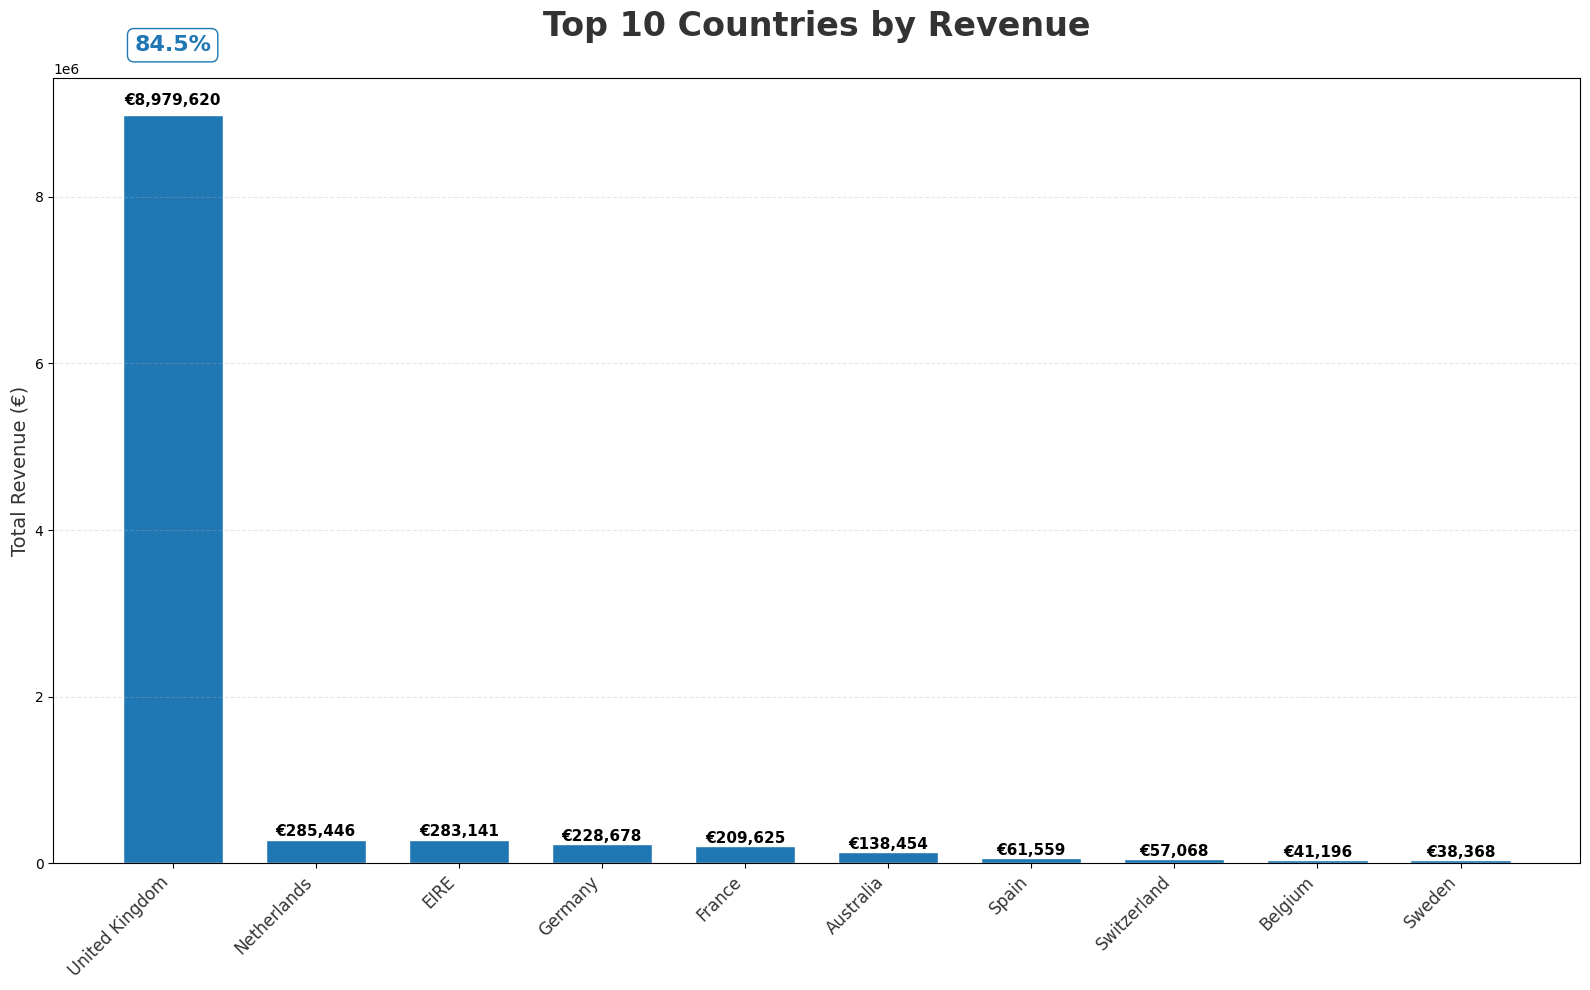

In [ ]:
country_revenue = df_sales.groupby('Country')['Revenue'].sum().reset_index()
country_revenue = country_revenue.rename(columns={'Revenue': 'TotalRevenue'})

total_revenue = country_revenue['TotalRevenue'].sum()
country_revenue['RevenuePercentage'] = (country_revenue['TotalRevenue'] / total_revenue * 100).round(2)

country_revenue = country_revenue.sort_values('TotalRevenue', ascending=False)
top_countries = country_revenue.head(10)

plt.figure(figsize=(16,10))
plt.style.use('default')

fig = plt.gcf()
fig.patch.set_facecolor('white')
ax = plt.gca()
ax.set_facecolor('white')

bars = plt.bar(range(len(top_countries)),
               top_countries['TotalRevenue'],
               width=0.7,
               edgecolor='white',
               linewidth=1)

plt.title('Top 10 Countries by Revenue', fontsize=24, fontweight='bold', pad=30, color='#333')
plt.ylabel('Total Revenue (€)', fontsize=14, color='#333')
plt.xlabel('')

plt.xticks(range(len(top_countries)), top_countries['Country'], rotation=45, ha='right', fontsize=12, color='#333')
ax.grid(axis='y', linestyle='--', alpha=0.3)

for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + height*0.01,
             f"€{height:,.0f}", ha='center', va='bottom', fontweight='bold', fontsize=11)


highest_revenue = top_countries.iloc[0]['TotalRevenue']
highest_percentage = top_countries.iloc[0]['RevenuePercentage']
plt.text(0, highest_revenue + highest_revenue*0.08,
         f'{highest_percentage:.1f}%', ha='center', va='bottom',
         fontweight='bold', fontsize=16, color='#1f77b4',
         bbox=dict(boxstyle="round,pad=0.3", facecolor='white', edgecolor='#1f77b4'))

plt.tight_layout()
plt.show()

The total revenue is predominantly dominated by the United Kingdom, accounting for 84.5% of the overall revenue

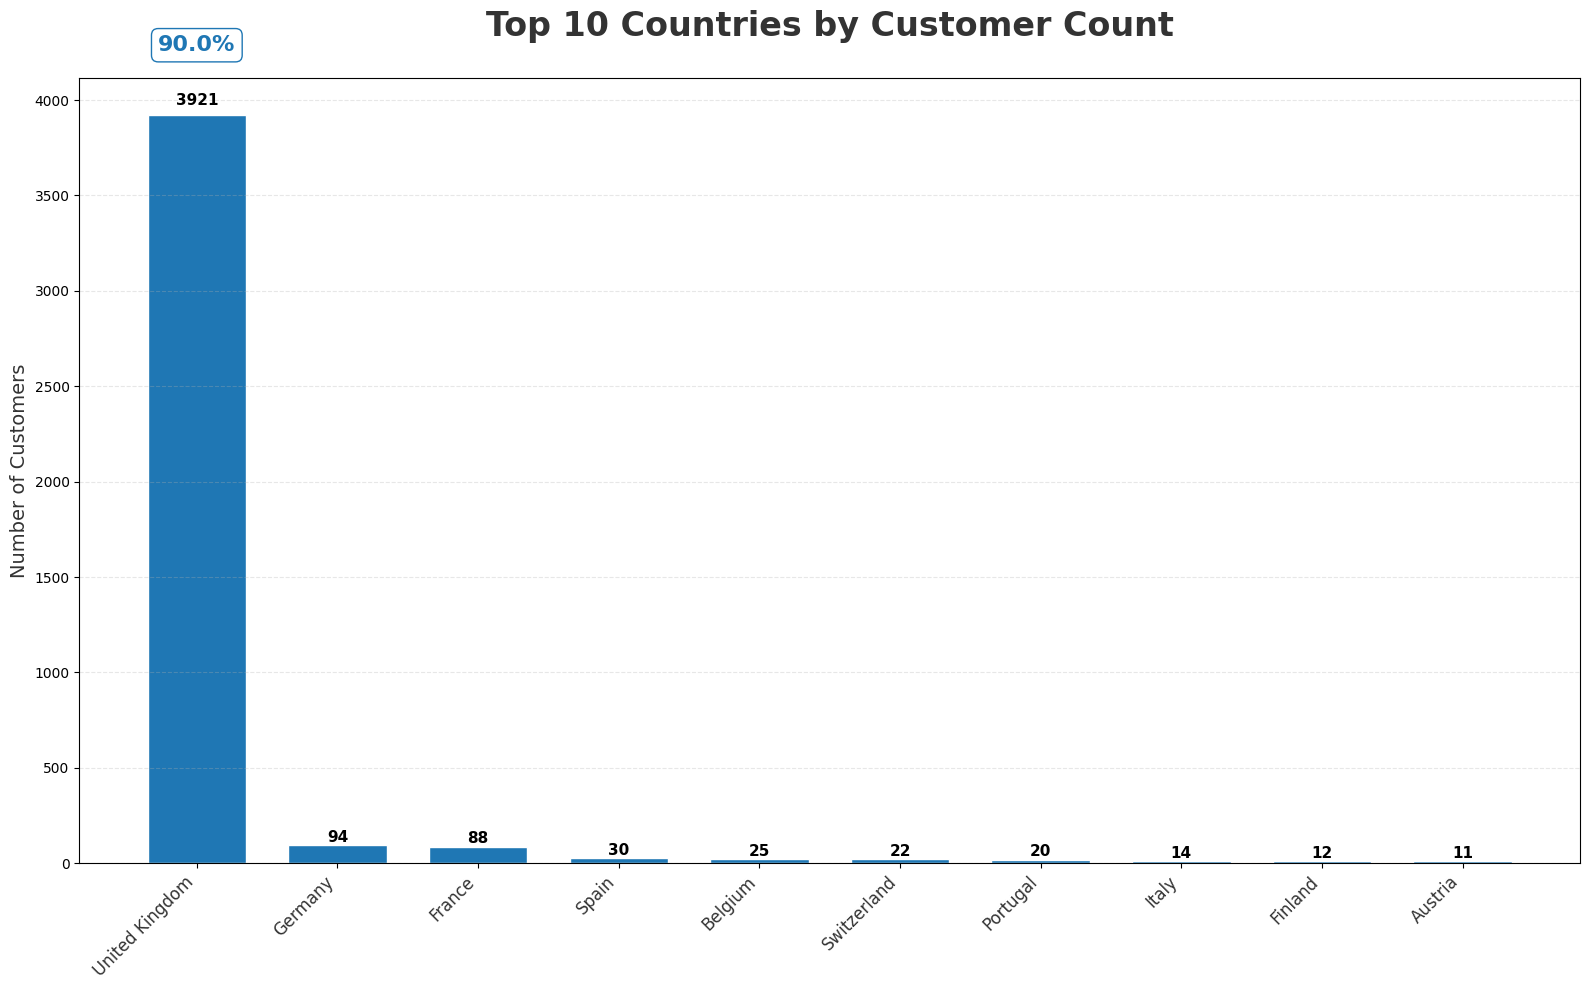

In [ ]:
customer_count = df_sales.groupby('Country')['CustomerID'].nunique().reset_index()
customer_count = customer_count.rename(columns={'CustomerID': 'UniqueCustomers'})

total_customers = customer_count['UniqueCustomers'].sum()
customer_count['CustomerPercentage'] = (customer_count['UniqueCustomers'] / total_customers * 100).round(2)

customer_count = customer_count.sort_values('UniqueCustomers', ascending=False)
top_countries = customer_count.head(10)

plt.figure(figsize=(16,10))
plt.style.use('default')

fig = plt.gcf()
fig.patch.set_facecolor('white')  # ubah background figure menjadi putih
ax = plt.gca()
ax.set_facecolor('white')         # ubah background axes menjadi putih

bars = plt.bar(range(len(top_countries)),
               top_countries['UniqueCustomers'],
               width=0.7,
               edgecolor='white',
               linewidth=1)

plt.title('Top 10 Countries by Customer Count', fontsize=24, fontweight='bold', pad=30, color='#333')
plt.ylabel('Number of Customers', fontsize=14, color='#333')
plt.xlabel('')

plt.xticks(range(len(top_countries)), top_countries['Country'], rotation=45, ha='right', fontsize=12, color='#333')

ax.grid(axis='y', linestyle='--', alpha=0.3)

for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + height*0.01,
             f"{height}", ha='center', va='bottom', fontweight='bold', fontsize=11)

highest_customers = top_countries.iloc[0]['UniqueCustomers']
highest_percentage = top_countries.iloc[0]['CustomerPercentage']
plt.text(0, highest_customers + highest_customers*0.08,
         f'{highest_percentage:.1f}%', ha='center', va='bottom',
         fontweight='bold', fontsize=16, color='#1f77b4',
         bbox=dict(boxstyle="round,pad=0.3", facecolor='white', edgecolor='#1f77b4'))

plt.tight_layout()
plt.show()


The United Kingdom is the dominant market, accounting for 84.5% of total revenue and 90.2% of total customers

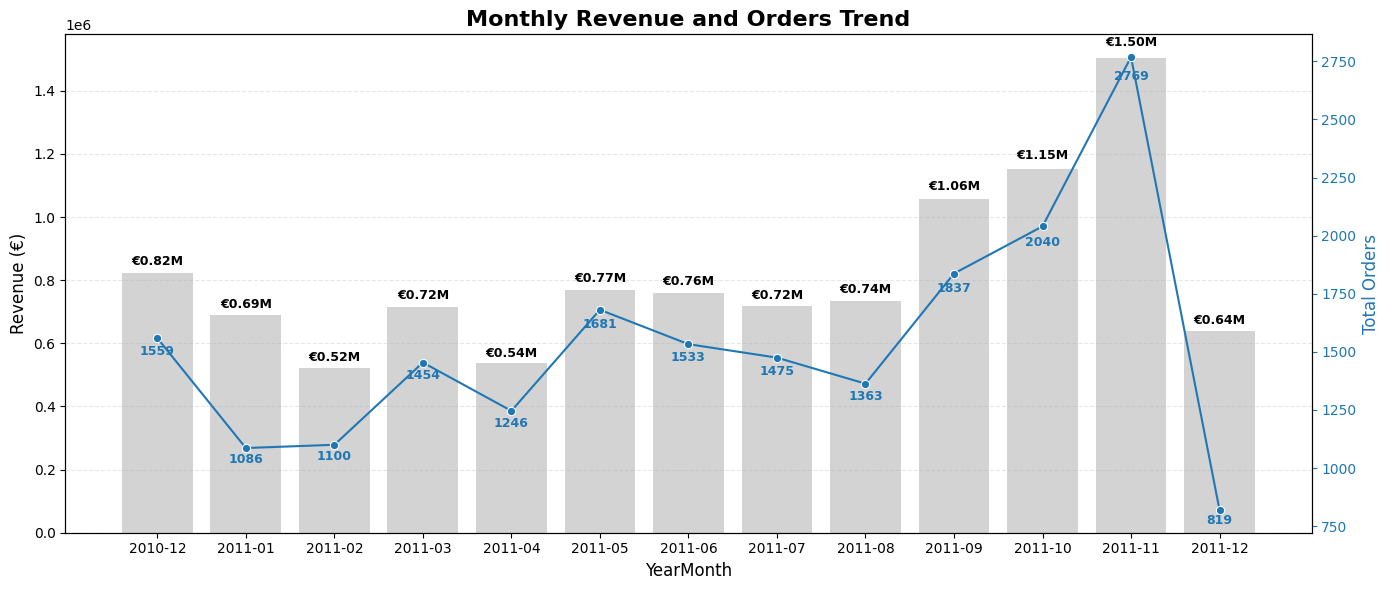

In [ ]:
monthly_revenue = df_sales.groupby('InvoiceYearMonth')['Revenue'].sum().reset_index()

monthly_orders = df_sales.groupby('InvoiceYearMonth')['InvoiceNo'].nunique().reset_index().rename(columns={'InvoiceNo':'TotalOrders'})

monthly_data = pd.merge(monthly_revenue, monthly_orders, on='InvoiceYearMonth')
monthly_data['InvoiceMonthStr'] = monthly_data['InvoiceYearMonth'].dt.strftime('%Y-%m')

fig, ax1 = plt.subplots(figsize=(14,6))

bar_color = '#D3D3D3'  # abu lebih terang
sns.barplot(data=monthly_data, x='InvoiceMonthStr', y='Revenue', color=bar_color, ax=ax1)
ax1.set_ylabel('Revenue (€)', fontsize=12)
ax1.set_xlabel('YearMonth', fontsize=12)
ax1.tick_params(axis='y')
ax1.grid(axis='y', linestyle='--', alpha=0.3)  # grid tipis

for i, row in monthly_data.iterrows():
    ax1.text(i, row['Revenue'] + 0.02*row['Revenue'], f"€{row['Revenue']/1_000_000:.2f}M",
             ha='center', va='bottom', fontsize=9, fontweight='bold', color='black')

ax2 = ax1.twinx()
line_color = '#1f77b4'  # warna biru default matplotlib
sns.lineplot(data=monthly_data, x='InvoiceMonthStr', y='TotalOrders', color=line_color, marker='o', sort=False, ax=ax2)
ax2.set_ylabel('Total Orders', fontsize=12, color=line_color)
ax2.tick_params(axis='y', colors=line_color)

for i, row in monthly_data.iterrows():
    ax2.text(i, row['TotalOrders'] - 0.02*row['TotalOrders'], f"{row['TotalOrders']}",
             ha='center', va='top', fontsize=9, fontweight='bold', color=line_color)

plt.title('Monthly Revenue and Orders Trend', fontsize=16, fontweight='bold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/tmp/ipython-input-2347245133.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sales['InvoiceDate'] = pd.to_datetime(df_sales['InvoiceDate'])
/tmp/ipython-input-2347245133.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sales['InvoiceYearMonth'] = df_sales['InvoiceDate'].dt.to_period('M')


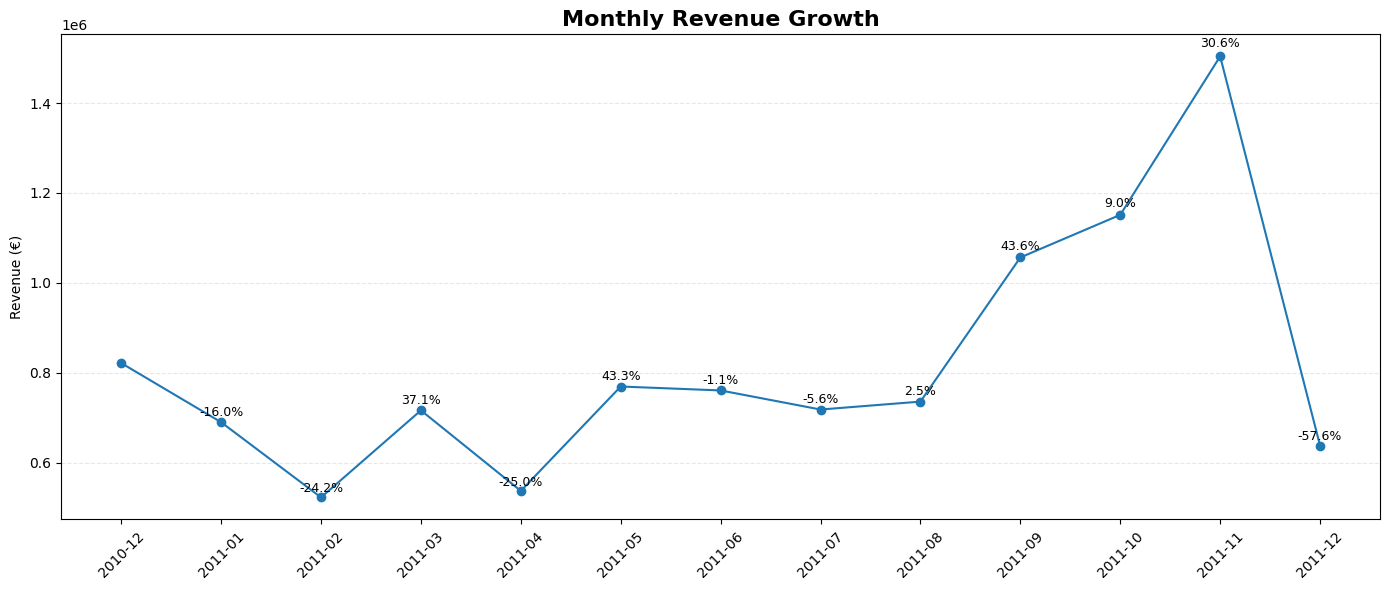

In [ ]:
df_sales['InvoiceDate'] = pd.to_datetime(df_sales['InvoiceDate'])
df_sales['InvoiceYearMonth'] = df_sales['InvoiceDate'].dt.to_period('M')

monthly_revenue = df_sales.groupby('InvoiceYearMonth')['Revenue'].sum().reset_index()
monthly_revenue['RevenueGrowth%'] = monthly_revenue['Revenue'].pct_change() * 100
monthly_revenue['InvoiceMonthStr'] = monthly_revenue['InvoiceYearMonth'].dt.strftime('%Y-%m')

plt.figure(figsize=(14,6))
plt.plot(monthly_revenue['InvoiceMonthStr'], monthly_revenue['Revenue'], marker='o', color='#1f77b4', label='Revenue')
plt.xticks(rotation=45)
plt.ylabel('Revenue (€)')
plt.title('Monthly Revenue Growth', fontsize=16, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.3)

for i, growth in enumerate(monthly_revenue['RevenueGrowth%']):
    if not pd.isna(growth):
        plt.text(i, monthly_revenue['Revenue'][i] + 0.01*monthly_revenue['Revenue'][i],
                 f"{growth:.1f}%", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

November 2011 was the peak month, with revenue reaching €1.50 million and a total of 2,789 orders, showing a 30.6% growth compared to the previous month

## Pareto Analysis

In [ ]:
product_revenue = df_sales.groupby('Description')['Revenue'].sum().sort_values(ascending=False)

product_revenue_percentage = product_revenue / product_revenue.sum() * 100
product_cumsum = product_revenue_percentage.cumsum()

pareto_products = product_cumsum[product_cumsum <= 80]

num_pareto_products = len(pareto_products)
total_products = len(product_revenue)
pareto_percentage = num_pareto_products / total_products * 100

print(f"Total number of products: {total_products}")
print(f"Number of products in Pareto (contributing 80% of revenue): {num_pareto_products}")
print(f"Percentage of products contributing 80% of revenue: {pareto_percentage:.2f}%")



Total number of products: 4026
Number of products in Pareto (contributing 80% of revenue): 824
Percentage of products contributing 80% of revenue: 20.47%


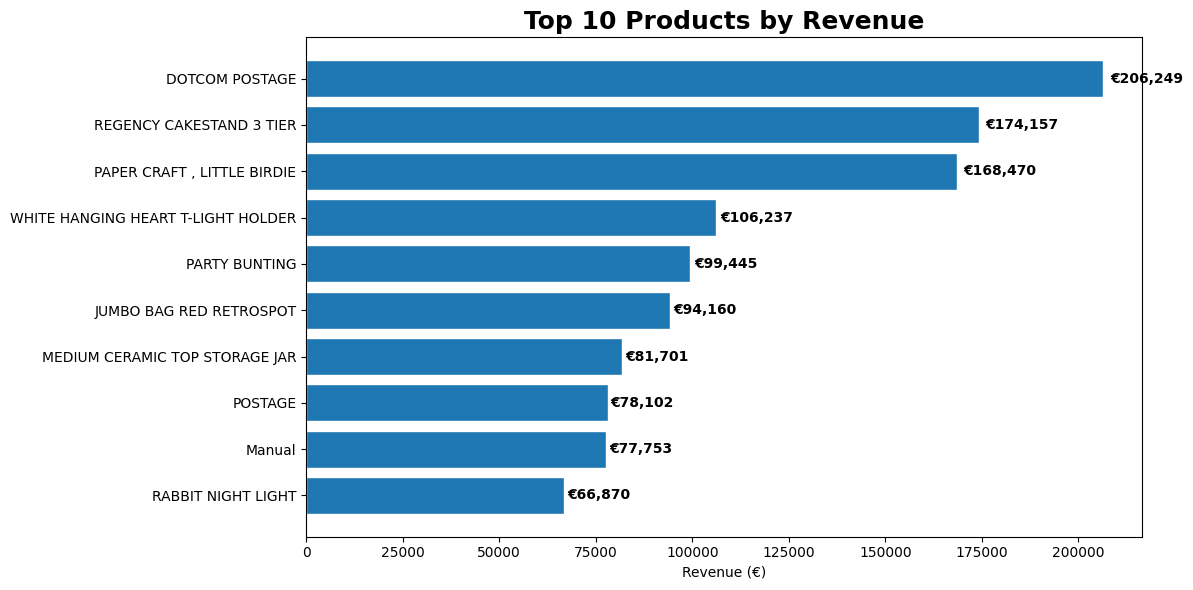

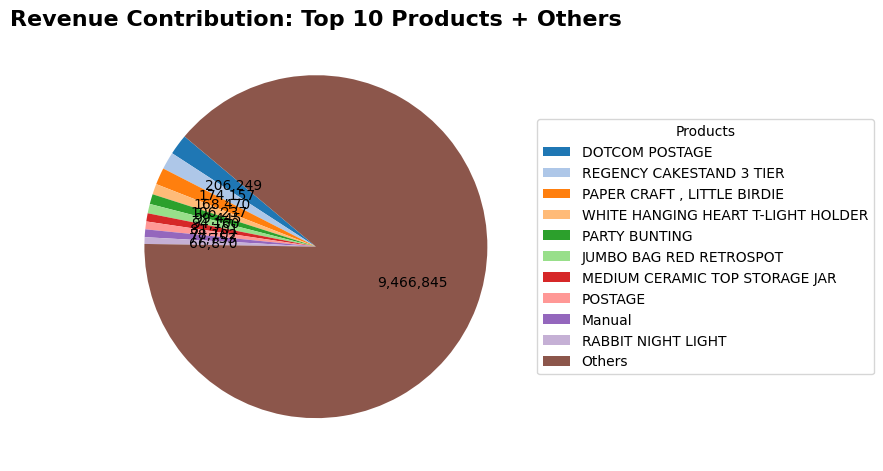

In [ ]:
top10 = product_revenue.head(10)
others_revenue = pd.Series({'Others': product_revenue[10:].sum()})
top10_with_others = pd.concat([top10, others_revenue])

top10_percentage = (top10_with_others / top10_with_others.sum() * 100).round(2)

plt.figure(figsize=(12, 6))
bars = plt.barh(top10.index, top10.values, color='#1f77b4', edgecolor='white')
plt.title('Top 10 Products by Revenue', fontsize=18, fontweight='bold')
plt.xlabel('Revenue (€)')

for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + width*0.01, bar.get_y() + bar.get_height()/2,
             f"€{width:,.0f}", va='center', fontsize=10, fontweight='bold')

plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(
    top10_with_others.values,
    labels=None,
    autopct=lambda p: f'{top10_with_others.sum() * p / 100:,.0f}',
    startangle=140,
    colors=plt.cm.tab20.colors
)

plt.legend(
    wedges,
    top10_with_others.index,
    title="Products",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1)
)

plt.title('Revenue Contribution: Top 10 Products + Others',
          fontsize=16, fontweight='bold', pad=5)  # <-- pad kecil biar judul lebih dempet
plt.tight_layout()
plt.show()

## Return Analysis

/tmp/ipython-input-3167323901.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f"€{height:,.0f} ({category_rev_percentage[i]}%)",


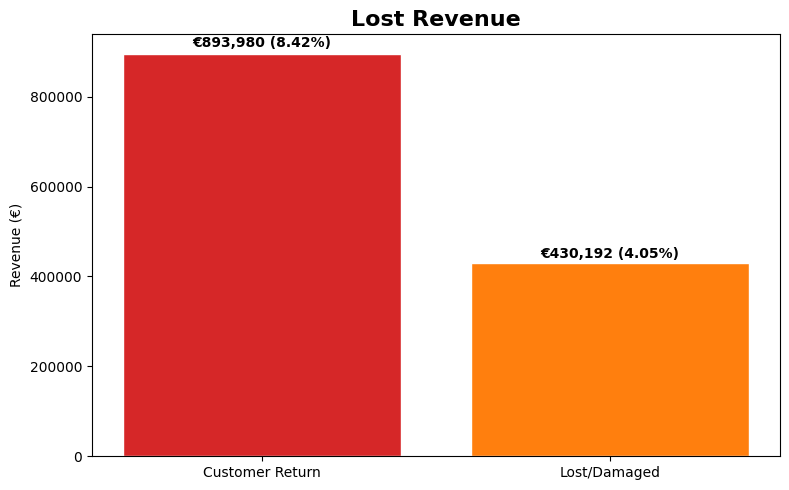

In [ ]:
adjustments = df_adjustment[df_adjustment['Category'].isin(['Lost/Damaged','Customer Return'])]
category_rev = adjustments.groupby('Category')['Revenue'].sum().sort_values()
total_revenue = df_sales['Revenue'].sum()
category_rev_percentage = (category_rev.abs() / total_revenue * 100).round(2)  # gunakan abs()

plt.figure(figsize=(8,5))
bars = plt.bar(category_rev.index, category_rev.abs(), color=['#d62728','#ff7f0e'], edgecolor='white')
plt.ylabel('Revenue (€)')
plt.title('Lost Revenue', fontsize=16, fontweight='bold')

for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + (0.01*height),
             f"€{height:,.0f} ({category_rev_percentage[i]}%)",
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()


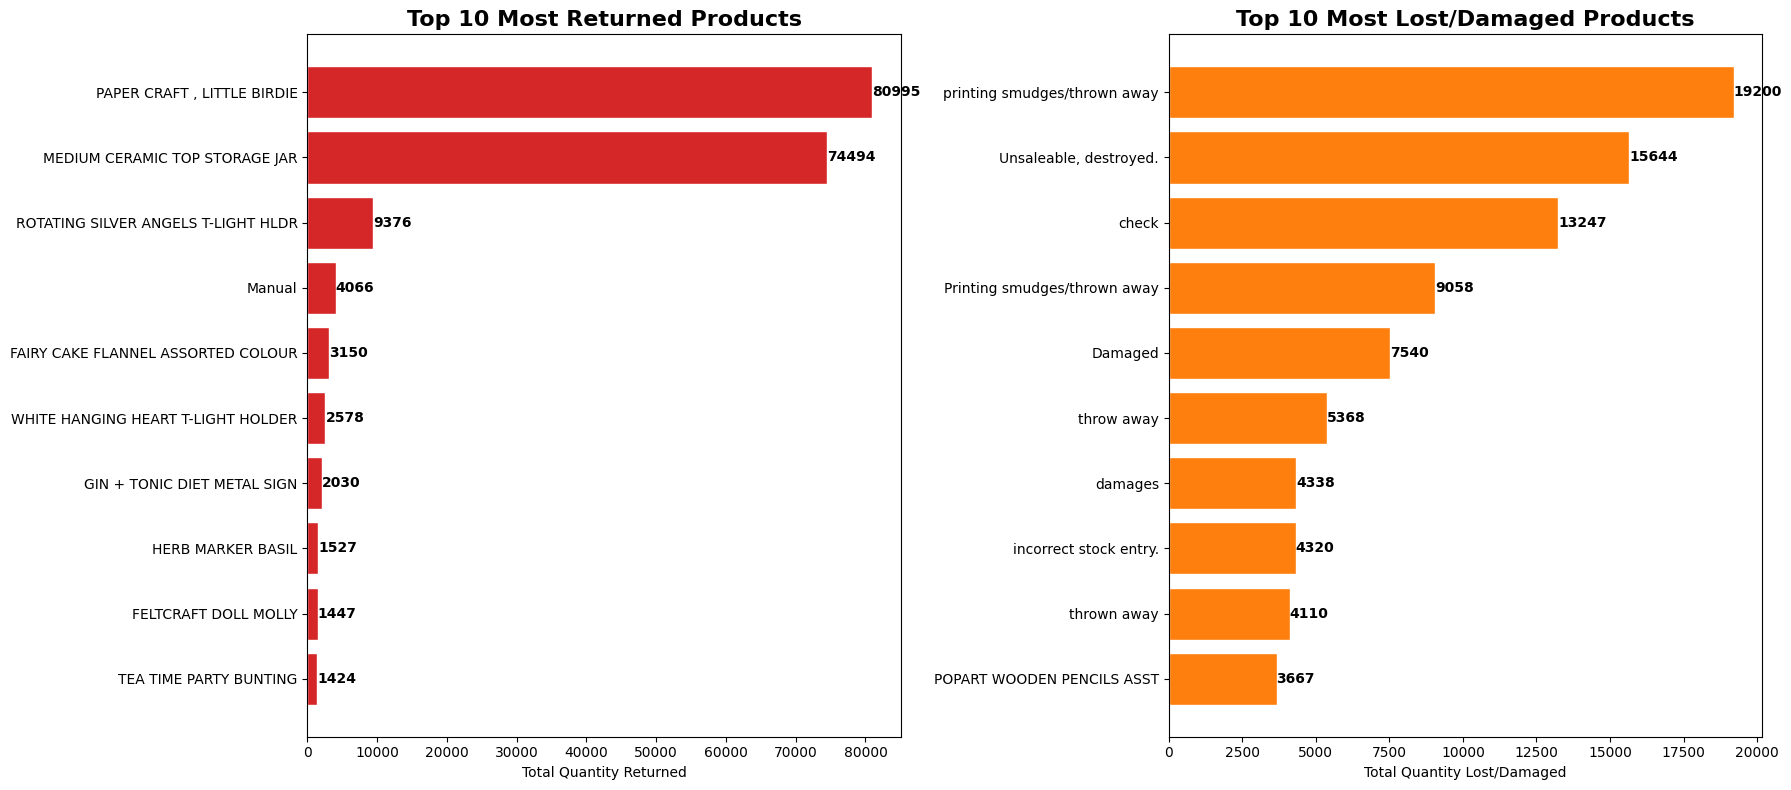

In [ ]:
returns = df_adjustment[df_adjustment['Category'] == 'Customer Return']
top_returned_products = returns.groupby('Description')['Quantity'].sum().abs().sort_values(ascending=False).head(10)

lost = df_adjustment[df_adjustment['Category'] == 'Lost/Damaged']
top_lost_products = lost.groupby('Description')['Quantity'].sum().abs().sort_values(ascending=False).head(10)

fig, axes = plt.subplots(1, 2, figsize=(18,8))

# Left: Top 10 Returned Products
bars = axes[0].barh(top_returned_products.index, top_returned_products.values, color='#d62728', edgecolor='white')
axes[0].set_xlabel('Total Quantity Returned')
axes[0].set_title('Top 10 Most Returned Products', fontsize=16, fontweight='bold')
axes[0].invert_yaxis()
for i, bar in enumerate(bars):
    width = bar.get_width()
    axes[0].text(width + 0.5, bar.get_y() + bar.get_height()/2,
                 f"{int(width)}", va='center', fontsize=10, fontweight='bold')

# Right: Top 10 Lost/Damaged Products
bars = axes[1].barh(top_lost_products.index, top_lost_products.values, color='#ff7f0e', edgecolor='white')
axes[1].set_xlabel('Total Quantity Lost/Damaged')
axes[1].set_title('Top 10 Most Lost/Damaged Products', fontsize=16, fontweight='bold')
axes[1].invert_yaxis()
for i, bar in enumerate(bars):
    width = bar.get_width()
    axes[1].text(width + 0.5, bar.get_y() + bar.get_height()/2,
                 f"{int(width)}", va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

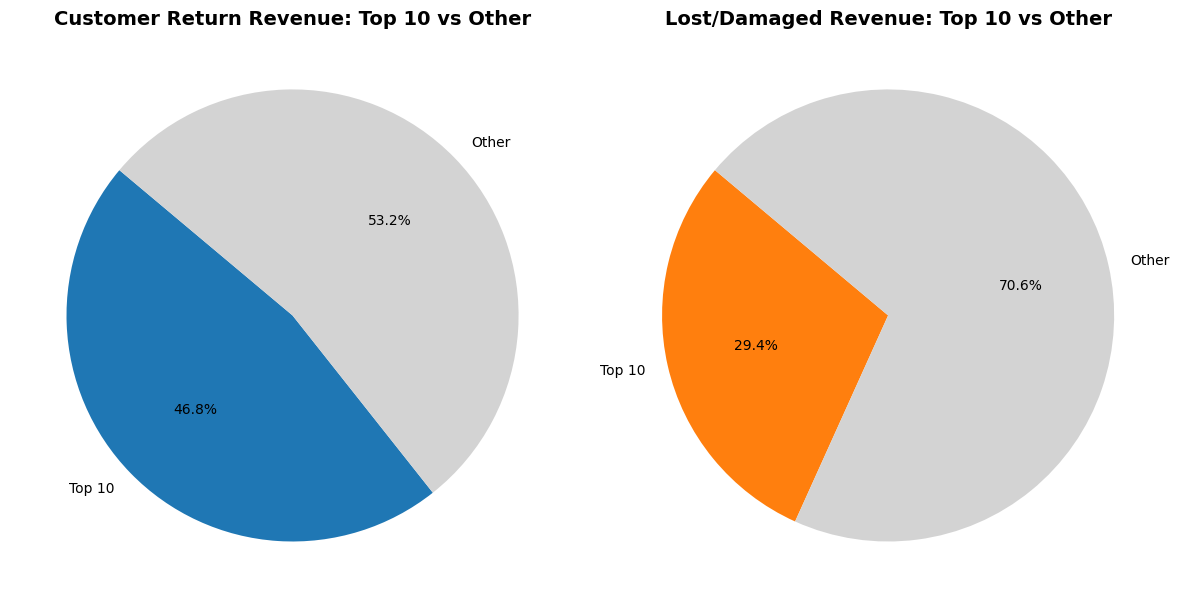

In [ ]:
# Top 10 returned products
top10_returned = top_returned_products.index
top_return_revenue = returns[returns['Description'].isin(top10_returned)]['Revenue'].abs().sum()
other_return_revenue = returns[~returns['Description'].isin(top10_returned)]['Revenue'].abs().sum()

# Top 10 lost/damaged products
top10_lost = top_lost_products.index
top_lost_revenue = lost[lost['Description'].isin(top10_lost)]['Revenue'].abs().sum()
other_lost_revenue = lost[~lost['Description'].isin(top10_lost)]['Revenue'].abs().sum()

fig, axes = plt.subplots(1, 2, figsize=(12,6))

# Left: Customer Return Revenue
axes[0].pie([top_return_revenue, other_return_revenue],
            labels=['Top 10', 'Other'],
            autopct='%1.1f%%',
            startangle=140,
            colors=['#1f77b4','#d3d3d3'])
axes[0].set_title('Customer Return Revenue: Top 10 vs Other', fontsize=14, fontweight='bold')

# Right: Lost/Damaged Revenue
axes[1].pie([top_lost_revenue, other_lost_revenue],
            labels=['Top 10', 'Other'],
            autopct='%1.1f%%',
            startangle=140,
            colors=['#ff7f0e','#d3d3d3'])
axes[1].set_title('Lost/Damaged Revenue: Top 10 vs Other', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

Top 10 products account for 63% of customer return losses, while lost/damaged items are widespread (82.3%), indicating systemic operational issues

## Cohort Analysis

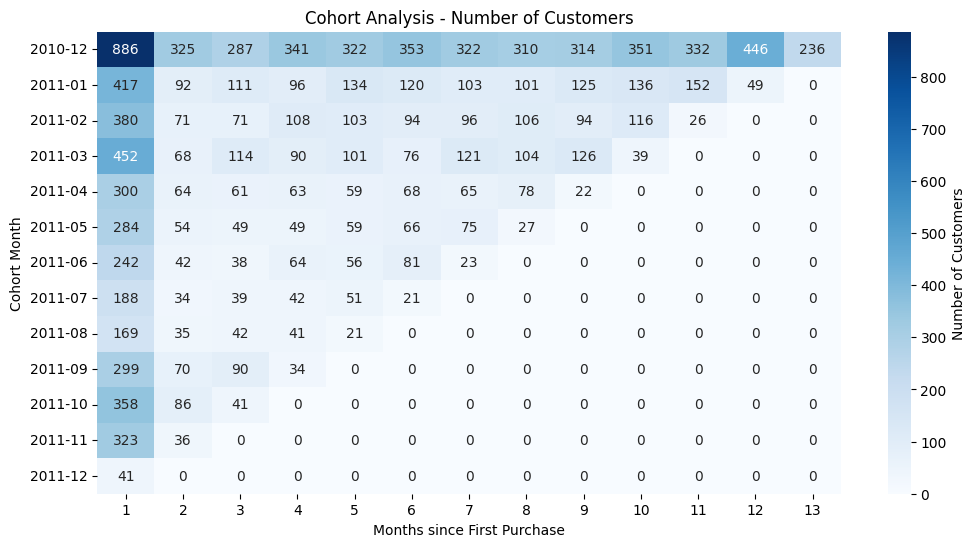

In [ ]:
# Create InvoiceMonth and CohortMonth columns
df_customer['InvoiceMonth'] = df_customer['InvoiceDate'].dt.to_period('M')
df_customer['CohortMonth'] = df_customer.groupby('CustomerID')['InvoiceMonth'].transform('min')

# Function to calculate months between dates (CohortIndex)
def get_month_diff(d1, d2):
    return (d1.dt.year - d2.dt.year) * 12 + (d1.dt.month - d2.dt.month) + 1

df_customer['CohortIndex'] = get_month_diff(df_customer['InvoiceDate'], df_customer['CohortMonth'].dt.to_timestamp())

# Count unique customers per cohort and month
cohort_data = df_customer.groupby(['CohortMonth', 'CohortIndex'])['CustomerID'].nunique().reset_index()

# Pivot table for heatmap
cohort_pivot = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='CustomerID')

# Replace NaN with 0 and convert to integer
cohort_counts = cohort_pivot.fillna(0).astype(int)

# Plot heatmap
plt.figure(figsize=(12,6))
sns.heatmap(cohort_counts, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Number of Customers'})
plt.title('Cohort Analysis - Number of Customers')
plt.ylabel('Cohort Month')
plt.xlabel('Months since First Purchase')
plt.show()


Customer cohorts show a steep decline after the first month, indicating low repeat activity. Early cohorts (2010) had higher acquisition, while later cohorts (2011) show fewer new customers and consistently low retention

## Segmentation

In [ ]:
# Set one day after the last transaction
snapshot_date = df_customer['InvoiceDate'].max() + dt.timedelta(days=1)

# RFM metrics
rfm = df_customer.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'InvoiceNo': 'count',                                     # Frequency
    'Revenue': 'sum'                                          # Monetary
}).reset_index()

rfm.rename(columns={'InvoiceDate': 'Recency',
                    'InvoiceNo': 'Frequency',
                    'Revenue': 'Monetary'}, inplace=True)

# Create R, F, M scores (1–4)
rfm['R_Score'] = pd.qcut(rfm['Recency'], 4, labels=[4,3,2,1]).astype(int)
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1,2,3,4]).astype(int)
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 4, labels=[1,2,3,4]).astype(int)

# Total Score
rfm['Total_Score'] = rfm[['R_Score','F_Score','M_Score']].sum(axis=1)

# 5. Customer segmentation
def customer_segment(row):
    if row['Total_Score'] >= 11:
        return "Champion"
    elif row['Total_Score'] == 10:
        return "Loyal"
    elif 7 <= row['Total_Score'] <= 9 and row['R_Score'] == 4:
        return "Recent"
    elif 7 <= row['Total_Score'] <= 9 and row['R_Score'] == 1:
        return "Cannot Lose Them"
    elif row['Total_Score'] == 9:
        return "Potential"
    elif 7 <= row['Total_Score'] <= 8:
        return "Average"
    elif 4 <= row['Total_Score'] <= 6:
        return "About To Sleep"
    elif row['Total_Score'] == 3:
        return "Lost Customer"
    else:
        return "Others"

# Apply segmentation
rfm['Segment'] = rfm.apply(customer_segment, axis=1)

rfm.head(10)


,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,Total_Score,Segment
0,12346.0,326,1,77183.60,1,1,4,6,About To Sleep
1,12347.0,2,182,4310.00,4,4,4,12,Champion
2,12348.0,75,31,1797.24,2,2,4,8,Average
3,12349.0,19,73,1757.55,3,3,4,10,Loyal
4,12350.0,310,17,334.40,1,1,2,4,About To Sleep
5,12352.0,36,85,2506.04,3,3,4,10,Loyal
6,12353.0,204,4,89.00,1,1,1,3,Lost Customer
7,12354.0,232,58,1079.40,1,3,3,7,Cannot Lose Them
8,12355.0,214,13,459.40,1,1,2,4,About To Sleep
9,12356.0,23,59,2811.43,3,3,4,10,Loyal


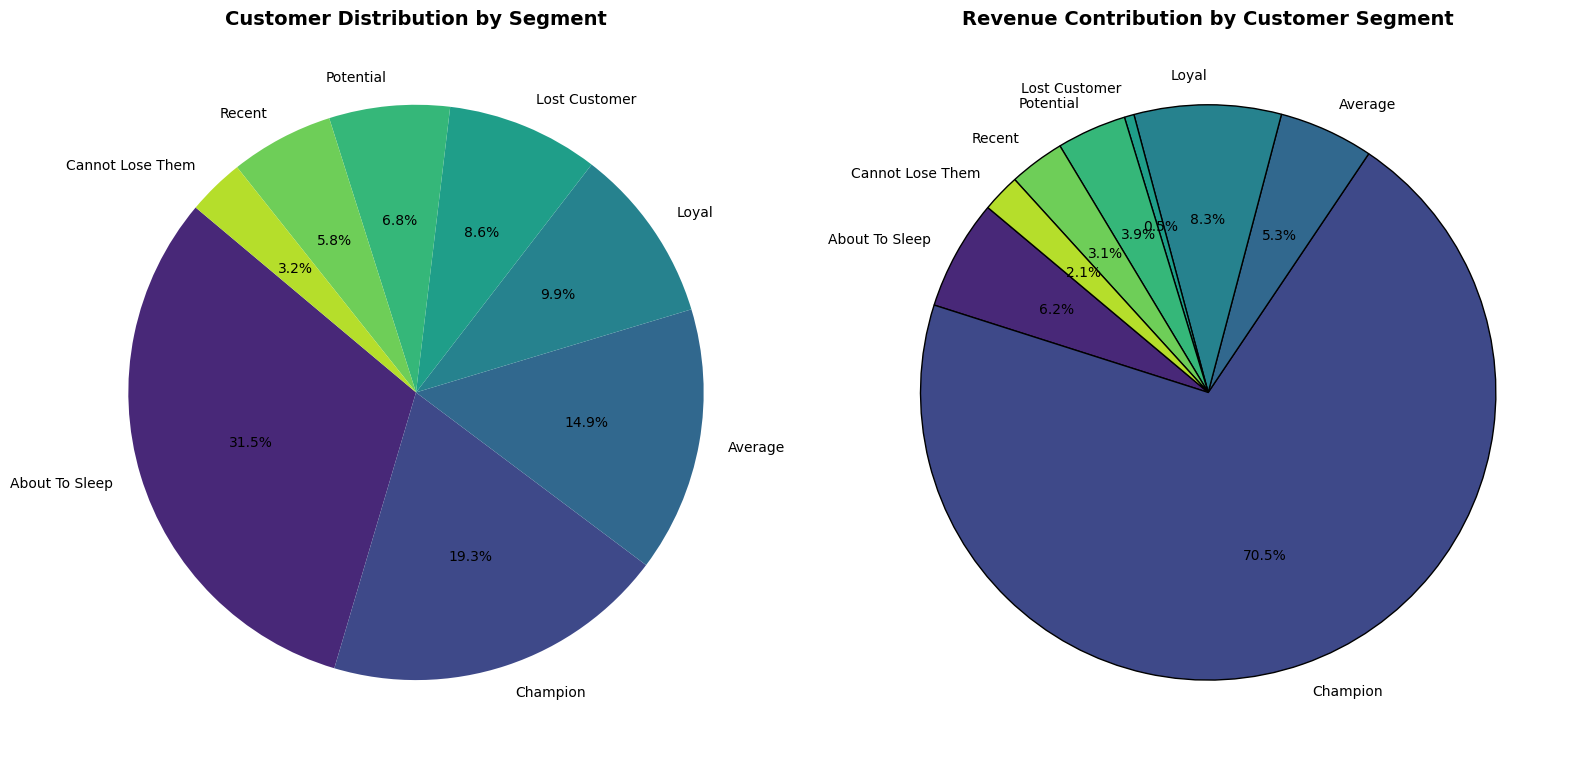

In [ ]:
segment_counts = rfm['Segment'].value_counts().reset_index()
segment_counts.columns = ['Segment', 'Count']

colors = sns.color_palette('viridis', len(segment_counts))

segment_revenue = rfm.groupby('Segment')['Monetary'].sum().reindex(segment_counts['Segment'])
segment_percentage = segment_revenue / segment_revenue.sum() * 100

fig, axes = plt.subplots(1, 2, figsize=(16,8))

# Pie chart: Customer count
axes[0].pie(segment_counts['Count'], labels=segment_counts['Segment'], autopct='%1.1f%%', startangle=140, colors=colors)
axes[0].set_title('Customer Distribution by Segment', fontsize=14, fontweight='bold')

# Pie chart: Revenue contribution
axes[1].pie(segment_percentage, labels=segment_percentage.index, autopct='%.1f%%', startangle=140, colors=colors, wedgeprops={'edgecolor':'k'})
axes[1].set_title("Revenue Contribution by Customer Segment", fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

An extreme Pareto effect is observed: 19.3% of customers (Champions) contribute 64.7% of total revenue

## Save

In [ ]:
df_sales.to_csv('df_sales.csv', index=False, float_format='%.2f', encoding='utf-8')
df_adjustment.to_csv('df_adjustment.csv', index=False, float_format='%.2f', encoding='utf-8')
df_customer.to_csv('df_customer.csv', index=False, float_format='%.2f', encoding='utf-8')
